In [1]:
#prepare imports etc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

%matplotlib inline

<h1>Feature selection: What determines the height of queueing SSU peaks?</h1>
<p>This notebook analyses i how far the mRNA classification into sets with or without queuing SSU peaks is predictable from mRNA features. Features were compiled from a range of literature data, the comilation from source data into the compiled data set was done using the script 'feature_compilation.py'. The output of this script is stored in file <a href='_Data/An_mRNA_Feature_Compilation.csv' target=_blank>'An_mRNA_Feature_Compilation.csv'</a> Features selected for inclusion in the final analysis are:</p>
<ul>
    <li><b>5' UTR length:</b> Determined as the longest 5' UTR length reported in any of the three studies by <a href='https://www.ncbi.nlm.nih.gov/pubmed/17101987' target=_blank>Miura <i>et al.</i> 2006</a>, <a href='https://www.ncbi.nlm.nih.gov/pubmed/18451266' target=_blank>Nagalakshmi <i>et al.</i> 2008</a> and <a href='https://www.ncbi.nlm.nih.gov/pubmed/23390610' target=_blank>Waern and Snyder 2013</a>.</li>
    <li><b>uORF presence:</b> Compiled from supplemental material in <a href='https://www.ncbi.nlm.nih.gov/pubmed/19213877' target=_blank>Ingolia <i> et al.</i> 2009</a>.</li>
    <li><b>Secondary Structure:</b> From RNA-specific PARS scores reported by <a href='https://www.ncbi.nlm.nih.gov/pubmed/20811459' target=_blank> Kertesz <i>et al.</i> 2010</a> by integrating the nucleotide-resolution PARS scores along the sequence and normalising by sequence length.</li>
    <li><b>Initiation rate:</b> Data were generated in <a href='https://www.ncbi.nlm.nih.gov/pubmed/23382661' target=_blank>Ciandrini <i>et al.</i> 2013</a> by fitting observed ribosome footprinting densities to computational models of ribosome movement.</li>
    <li><b>ORF length:</b> on codons, determined from the systematic <a href='https://downloads.yeastgenome.org/sequence/S288C_reference/orf_protein/' target=_blank>protein list</a> for the S288C reference genome.</li>
    <li><b>Intron presence:</b> Determined by comparing the 'genomic' and 'coding' entries for each gene in the <a href='https://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/' target=_blank>gene list</a> for the S288C reference genome.</li>
    <li><b>Decoding speed:</b> Determined as the decoding speed of the slowest 20 codon stretch in a gene, based on decoding times reported in <a href='https://www.ncbi.nlm.nih.gov/pubmed/24357599' target=_blank>Chu <i>et al.</i> 2014</a>.</li>
    <li><b>3' UTR length:</b> Determined as the longest 3' UTR length reported in any of the two studies by <a href='https://www.ncbi.nlm.nih.gov/pubmed/18451266' target=_blank>Nagalakshmi <i>et al.</i> 2008</a> and <a href='https://www.ncbi.nlm.nih.gov/pubmed/23390610' target=_blank>Waern and Snyder 2013</a>.</li></li>
    <li><b>Poly proline runs:</b> Length of the longest run of proline residues in the protein sequence, determined from the systematic <a href='https://downloads.yeastgenome.org/sequence/S288C_reference/orf_protein/' target=_blank>protein list</a> for the S288C reference genome.</li>
    <li><b>Positive charge runs:</b> Length of the longest run of consecutive lysine or arginine residues, determined from the systematic <a href='https://downloads.yeastgenome.org/sequence/S288C_reference/orf_protein/' target=_blank>protein list</a> for the S288C reference genome.</li>
</ul>

In [2]:
feature_frame = pd.read_csv('_Data/An_mRNA_Feature_Compilation.csv').set_index('Gene')
#remove any entries where the 5'-UTR is <45 nt, where no second footprint is observable
feature_frame = feature_frame.loc[feature_frame['5_UTR']>45]
#replace any nans with 0
feature_frame = feature_frame.fillna(0)
#select the set of features to use in the lasso analysis
selected_features = ['5_UTR','uORF','Structure','InitC','Length','Intron','minSpeed','3_UTR','poly_P','poly_KR']
X = np.array(feature_frame[selected_features])

<h1>Classification</h1>

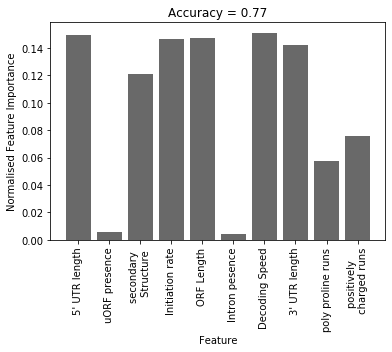

In [3]:
#select the categorical targets (Peak Calls) for this analysis
y_cat = np.array(feature_frame['PeakCall'])

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25,random_state=42)

#construct and apply a pipeline that scales the data and fits the Extra Trees Classifier
scaler = StandardScaler()
clf = ExtraTreesClassifier(n_estimators=10,random_state=24)
cat_pipeline = make_pipeline(scaler, clf)
cat_pipeline.fit(X_train,y_train)

#normalise coefficents
coefs = abs(clf.feature_importances_) / sum(clf.feature_importances_  )

#Construct human readable labels
labels = ['5\' UTR length','uORF presence','secondary \n Structure','Initiation rate','ORF Length','Intron pesence','Decoding Speed','3\' UTR length','poly proline runs','positively \n charged runs']

#determine the accuracy of the prediction
y_pred = cat_pipeline.predict(X_test)

plt.close()
fig,ax = plt.subplots()
x = np.arange(len(labels))
ax.bar(x, coefs,color='Dimgrey')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.title('Accuracy = ' + "{:4.2f}".format(accuracy_score(y_test,y_pred)))
plt.xticks(rotation='vertical')
plt.ylabel('Normalised Feature Importance')
plt.xlabel('Feature')
#plt.savefig('Features.svg')
plt.show()

<h1>Control Classification</h1>
<p>This section was introduced to test how meaningful predictions from the Classification analysis are. It repeats the analysis above with a randomly assembled target dataset rand_y_cat.</p>

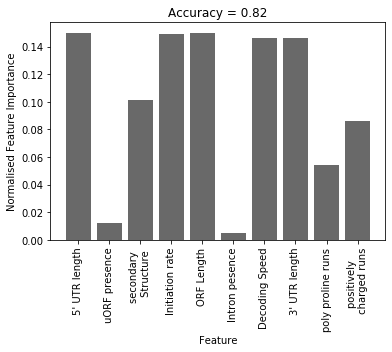

In [4]:
#assemble a control dataset of equal length and equal proportion of True points as y_cat, but where True points are randomly assigned
rand_y_cat = np.array([False] * len(y_cat))
rand_y_cat[np.random.choice(len(y_cat),len(y_cat[y_cat]))]=True

X_train, X_test, y_train, y_test = train_test_split(X, rand_y_cat, test_size=0.25,random_state=42)

#construct and apply a pipeline that scales the data and fits the Extra Trees Classifier
scaler = StandardScaler()
clf = ExtraTreesClassifier(n_estimators=10,random_state=24)
cat_pipeline = make_pipeline(scaler, clf)
cat_pipeline.fit(X_train,y_train)

#normalise coefficents
coefs = abs(clf.feature_importances_) / sum(clf.feature_importances_  )

#Construct human readable labels
labels = ['5\' UTR length','uORF presence','secondary \n Structure','Initiation rate','ORF Length','Intron pesence','Decoding Speed','3\' UTR length','poly proline runs','positively \n charged runs']

#determine the accuracy of the prediction
y_pred = cat_pipeline.predict(X_test)

plt.close()
fig,ax = plt.subplots()
x = np.arange(len(labels))
ax.bar(x, coefs,color='Dimgrey')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.title('Accuracy = ' + "{:4.2f}".format(accuracy_score(y_test,y_pred)))
plt.xticks(rotation='vertical')
plt.ylabel('Normalised Feature Importance')
plt.xlabel('Feature')
#plt.savefig('Features.svg')
plt.show()

<p><b>Comment:</b> Both the accuracy, and the relative importance individual features make for the prediction, appear very similar with the real and random datasets. We trace this back to the particular features of the dataset: first the binary dataset has a small proportion of "True" values (~19%). This means that even if True values are picked at random, the majority of data points will be correctly labelled as False as long as the classification algorithm simply selects the right proportion of True points. Second, the data are a mixture of categorical data and numerical data. The decision tree simply has more branch points for continuous variables, meaning that these variables will on average be more powerful predictors even (or especially) for random predictions.</p>